<h1 style="font-size:3rem;color:orange;">Predicting Loan E-Signatures</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import time

### Import Data

In [2]:
df_users_financial = pd.read_csv("../data/processed/new_P39-Financial-Data.csv")

### Data Peek

In [3]:
df_users_financial.head()

,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,...,ext_quality_score_2,inquiries_last_month,home_owner,has_debt,pay_schedule_bi-weekly,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly,personal_account_months,e_signed
0,7629673,40,3135,3,3,550,36200,0.737398,0.903517,0.487712,...,0.380918,10,1,1,True,False,False,False,30,1
1,3560428,61,3180,6,3,600,30150,0.738510,0.881027,0.713423,...,0.630720,9,0,1,False,False,False,True,86,0
2,6934997,23,1540,0,0,450,34550,0.642993,0.766554,0.595018,...,0.531712,7,0,1,False,False,False,True,19,0
3,5682812,40,5230,6,1,700,42150,0.665224,0.960832,0.767828,...,0.592552,8,0,1,True,False,False,False,86,1
4,5335819,33,3590,5,2,1100,53850,0.617361,0.857560,0.613487,...,0.744634,12,0,1,False,False,True,False,98,0


# Data Pre-processing

### Remove the label from the features

In [4]:
label = df_users_financial['e_signed']
df_users_financial = df_users_financial.drop(columns = 'e_signed')

### Split the dataset into training and test sets

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(df_users_financial, 
                                                    label,
                                                    test_size = 0.2,
                                                    random_state = 42)
print(X_train.shape)
print(X_test.shape)

X_train.head()

(14326, 21)
(3582, 21)


,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,...,ext_quality_score,ext_quality_score_2,inquiries_last_month,home_owner,has_debt,pay_schedule_bi-weekly,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly,personal_account_months
2698,2322503,24,7098,5,1,600,31500,0.667077,0.906873,0.442824,...,0.628218,0.428218,7,1,1,True,False,False,False,86
7514,9816220,49,3200,5,5,500,50650,0.631218,0.966399,0.571481,...,0.694489,0.594489,19,0,1,True,False,False,False,27
12650,7940682,55,2660,6,1,400,41850,0.672894,0.955221,0.705386,...,0.760892,0.560892,21,0,1,True,False,False,False,86
5094,3661668,39,3120,3,1,2600,76100,0.749875,0.956253,0.581586,...,0.699007,0.799007,8,0,1,True,False,False,False,92
5018,6964638,52,3150,3,1,1200,33200,0.615360,0.837403,0.276529,...,0.417729,0.517729,5,1,1,False,True,False,False,38


### Filter model data

In [6]:
# Purge user identification, persist to associate the prediction to the user it came from 
user_identification = 'entry_id'

train_identifier = X_train[user_identification]
X_train = X_train.drop(columns = [user_identification])

test_identifier = X_test[user_identification]
X_test = X_test.drop(columns = [user_identification])

### Feature Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

# To normalize features
standard_scaler_X = StandardScaler()

# Scale the training & test datasets, persist results to a new dataframe
X_train2 = pd.DataFrame(standard_scaler_X.fit_transform(X_train))
X_test2 = pd.DataFrame(standard_scaler_X.transform(X_test))

# Retrieve columns for the standardized training & test sets 
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values

# Recuperate indexes 
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values

# Convert original training set into the new training set
X_train = X_train2
X_test = X_test2

X_train.head()

,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,home_owner,has_debt,pay_schedule_bi-weekly,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly,personal_account_months
2698,-1.597641,2.270284,0.651523,-0.936948,-0.508332,-1.930241,-0.264107,0.521042,-1.128877,-0.639225,0.028956,-1.392286,0.149269,1.162089,0.511949,0.819540,-0.300983,-0.352831,-0.512492,1.742054
7514,0.510466,-0.308489,0.651523,0.512315,-0.652099,-0.682192,-0.661641,1.610914,-0.098686,0.987289,0.505084,-0.200426,3.423198,-0.860519,0.511949,0.819540,-0.300983,-0.352831,-0.512492,-0.793974
12650,1.016412,-0.665733,1.093334,-0.936948,-0.795866,-1.255708,-0.199622,1.406255,0.973524,0.600835,0.982160,-0.441256,3.968853,-0.860519,0.511949,0.819540,-0.300983,-0.352831,-0.512492,1.742054
5094,-0.332777,-0.361414,-0.232101,-0.936948,2.367001,0.976443,0.653773,1.425159,-0.017775,0.069607,0.537544,1.265594,0.422096,-0.860519,0.511949,0.819540,-0.300983,-0.352831,-0.512492,1.999955
5018,0.763439,-0.341567,-0.232101,-0.936948,0.354268,-1.819448,-0.837440,-0.750887,-2.460447,-2.124629,-1.483315,-0.750655,-0.396386,1.162089,0.511949,-1.220197,3.322447,-0.352831,-0.512492,-0.321155


# Model Building

### Training Data

In [8]:
# Split the training set into a 80/20 training/validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,
                                                    test_size = 0.2,
                                                    random_state = 42)

### Metrics Function

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Evaluates model scores and concatenates results to a DataFrame
def evaluate_scores_and_concat(y_validation, y_predict, model_name, results_dataframe): 
    
    # Get scores
    accuracy = accuracy_score(y_validation, y_predict)   # CorrectPredicts / TotalPredicts  
    precision = precision_score(y_validation, y_predict) # TP / (TP+FP)
    recall = recall_score(y_validation, y_predict)       # TP / (TP+FN)
    f1 = f1_score(y_validation, y_predict)               # 2*(precision*recall) / (precision+recall)
    
    # Transfer scores to a DataFrame
    new_results = pd.DataFrame([[model_name, accuracy, precision, recall, f1]],
            columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    
    # Concatenate results to the results_dataframe vertically
    results_dataframe = pd.concat([results_dataframe, new_results], axis=0).reset_index(drop=True)
    
    return results_dataframe

## Logistic Regression

### Training

In [10]:
from sklearn.linear_model import LogisticRegression

# Add 'l1' penalty (lasso regularization)
model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

# Train model on the training set
model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='saga')

### Evaluation

In [11]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Initialize a results DataFrame
df_results = pd.DataFrame()

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Logistic Regression (Lasso)', df_results)

# Display
df_results.head()

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.585136,0.594782,0.722977,0.652644


## Support Vector Classification

### SVC (Linear) Training

In [12]:
from sklearn.svm import SVC

# Add linear kernel
model = SVC(kernel='linear', random_state=42)

# Train model on the training set
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### SVC (Linear) Evaluation

In [13]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'SVC (Linear)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.585136,0.594782,0.722977,0.652644
1,SVC (Linear),0.585136,0.592516,0.737864,0.657250


### SVC (RBF) Training

In [14]:
# Radial Basis Function kernel (default)
model = SVC(kernel='rbf', random_state=42)

# Train model on the training set
model.fit(X_train, y_train)

SVC(random_state=42)

### SVC (RBF) Evaluation

In [15]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'SVC (RBF)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.585136,0.594782,0.722977,0.652644
1,SVC (Linear),0.585136,0.592516,0.737864,0.657250
2,SVC (RBF),0.599442,0.615340,0.685437,0.648500


## Random Forest Classifier

### Training

In [16]:
from sklearn.ensemble import RandomForestClassifier

# 100 trees
model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state=42)

# Train model on the training set
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

### Evaluation

In [17]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Random Forest Classifier (n=100)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.585136,0.594782,0.722977,0.652644
1,SVC (Linear),0.585136,0.592516,0.737864,0.657250
2,SVC (RBF),0.599442,0.615340,0.685437,0.648500
3,Random Forest Classifier (n=100),0.625960,0.648462,0.668608,0.658381


### Confusion Matrix

<Axes: >

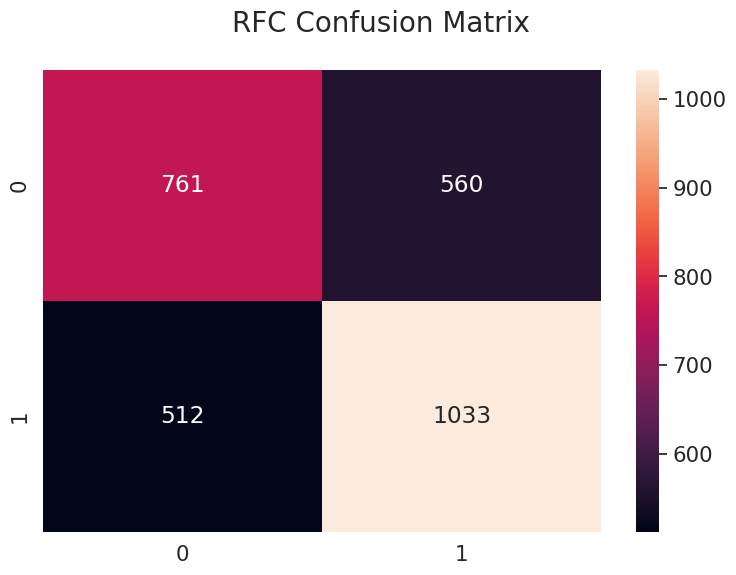

In [26]:
# Create a confusion matrix with the validation labels and our model's predictions
conf_matrix = confusion_matrix(y_validation, y_predict)

# Plot confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (9,6))
plt.suptitle("RFC Confusion Matrix", fontsize=20)
sn.set(font_scale=1.4)
sn.heatmap(df_conf_matrix, annot=True, fmt='g')

### K-Folds Cross Validation

Estimate how well the model is likely to generalize to unseen data

In [19]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

print("Cross Validated Scores Mean: %0.5f Std: (+/- %0.5f)" % (accuracies.mean(), accuracies.std() * 2))

Cross Validated Scores Mean: 0.62478 Std: (+/- 0.02322)


We discover that the Random Forest Classifier has provided our best estimates thus far as a baseline model and move forward with hyperparameter tuning

## Model Tuning

### Grid Search: Round One | Entropy

In [66]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
parameter_grid = {
                  # Number of decision trees
                  'n_estimators': [50, 100, 150], 
                  # Max depth of each decision tree
                  'max_depth': [3, None],
                  # Max number of features to consider when looking for best split
                  'max_features': [1, 5, 10],
                  # Min number of samples required to split an internal node
                  'min_samples_split': [2, 5, 10],
                  # Min number that a leaf node must contain
                  'min_samples_leaf': [1, 5, 10],
                  # If true, each tree is trained on a random subset of training data w/ replacement
                  'bootstrap': [True, False],
                  # Function to measure the quality of a split
                  'criterion': ["entropy"]
                  }

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameter_grid,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)

start_time = time.time()
grid_search = grid_search.fit(X_train, y_train)
end_time= time.time()

# Transfer results to a DataFrame
df_hyperparams = pd.DataFrame([grid_search.best_params_])
df_hyperparams.insert(0, "model", "Random Forest Classifier")
df_hyperparams.insert(1, "grid_search_round", "1")
df_hyperparams.insert(2, "best_accuracy", f"{grid_search.best_score_:.6f}")
df_hyperparams['time_seconds'] = f"{end_time - start_time:.2f}"

# Display
df_hyperparams

,model,grid_search_round,best_accuracy,bootstrap,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,time_seconds
0,Random Forest Classifier,1,0.633072,False,entropy,None,5,5,2,100,1684.35
